# Hello!
This series of tutorials introduces the basic procedure in the paper <b>Quantifying Explainability of Saliency Methods in Deep Neural Networks</b>. The project introduces 2 main things:
<ol>
    <li> A 10-class synthetic cells dataset. The dataset consists of images of 10 different types of cells (one of them is blank) placed in 3 different types of background. They are synthetic, and thus can be generated on demand. But the core feature is the availability of <b>ground-truth heatmaps</b>, designed to provide a more objective and reliable way to quantify the strengths and weaknesses of many heatmap-based XAI methods available nowadays.
    <li> A metric defined to quantify heatmaps' values. We introduce the <i>five-band score</i> and the stratification process to accompany it. Depending on context, different scores may be needed, but we hope eXplainable artificial intelligence (XAI) will grow with a good spirit of objectivity, by developing good methods of quantification.

</ol>

The tutorial series contains:
<ol>
    <li> Showcase of what data we are introducing, and how to prepare them.
    <li> How to prepare data using pytorch API.
    <li> How to train deep neural network model.
    <li> How to quantify heatmap, the main objective of the paper. 
</ol>
As of now, the project is only available in python, and the deep learning/deep neural network model is only implemented using pytorch. You can contact me <a>ericotjoa@gmail.com</a> if you are interested to build other implementations.<br>

Sincerely, <br>
Erico

In [1]:
import os, sys
import general_config 
print(general_config.ROOTDIR) # Edit the root directory setting in _tutorials/general_config.py
sys.path.append(general_config.ROOTDIR)

import numpy as np
import matplotlib.pyplot as plt
from pipeline.objgen.random_simple_gen_implemented import TenClassesRandomFetcher, TenClassesPyIO

# Show case one data
First, set up the object TenClassesRandomFetcher() that has the methods to draw one of the available data samples. By using <i>general_meta_setting=None, explanation_setting=None</i>, the default setting is used.

In [2]:
data_sampler = TenClassesRandomFetcher()
data_sampler.setup0001(general_meta_setting=None, explanation_setting=None)

Set <i>y0</i> to either 0,1,...,8 or 9 and bg_rand to 0,1 or 2. <br>
<ul>
<li><i>y0</i> refers to the type of cells we want to sample.
<li><i>bg_rand</i> refers to the type of background to place the cell in.
</ul>
In the following, we focus on (1) <i>cimg</i> (the picture containing a single cell of interest) and (2) <i>heatmap</i>. The other things are (3) <i>cobj</i> is a python object with methods to construct the cell of a given type (with randomness included) and (4) <i>variables</i> is a dictionary containing the setup settings used to generate the cell.<br><br>
The default image dimension is (512,512).

In [3]:
y0, bg_rand = 2,1
cobj, cimg, heatmap, variables = data_sampler.draw_one_sample(y0, bg_rand) 

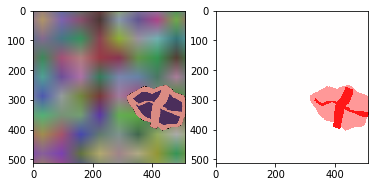

In [4]:
%matplotlib inline
plt.figure()
plt.gcf().add_subplot(121)
plt.gca().imshow(cimg)
plt.gcf().add_subplot(122)
plt.gca().imshow(heatmap, cmap='bwr', vmin=-1, vmax=1)

## Showcase classes of data
There are 10 classes of data (shown along the columns in the figure below) with 3 types of background (shown down the row).<br><br>
In the default setting (defined in pipeline.objgen.random_simple_generator.py), heatmaps colors are set as the following: <br> 

1. localizaton is 0.4 (light red color), <br>
2. discriminatory feature is 0.9 (deep red color) and <br>
3. everything else is 0 (white color). <br>

The heatmap takes in values from -1 to 1, and negative values are sometimes considered features that contribute <i>against</i> the prediction, which, by the way we define the data, should not appear in the heatmap. 

In [5]:
# define a function just to display the images nicely
def create_multi_axes_figures(settings, figsize=(12,12), off_ticks=True, off_heatmap=True):
    fig = plt.figure(figsize=figsize)
    for axpos, img, title, is_heatmap in settings:
        if not is_heatmap:
            vmin, vmax = 0.,1.
            cmap=None
        else:
            vmin, vmax = -1.,1.
            cmap = 'bwr'
        fig.add_subplot(*axpos)
        plt.gca()
        cax = plt.gca().imshow(img, vmin=vmin, vmax=vmax, cmap=cmap)
        if title is not None:
            plt.gca().set_title(title)
        
        plt.gca().set_xlim(0,512)
        plt.gca().set_ylim(0,512)
        if off_ticks:
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
        if is_heatmap:
            if not off_heatmap:
                plt.colorbar(cax,fraction=0.04)
    plt.tight_layout()

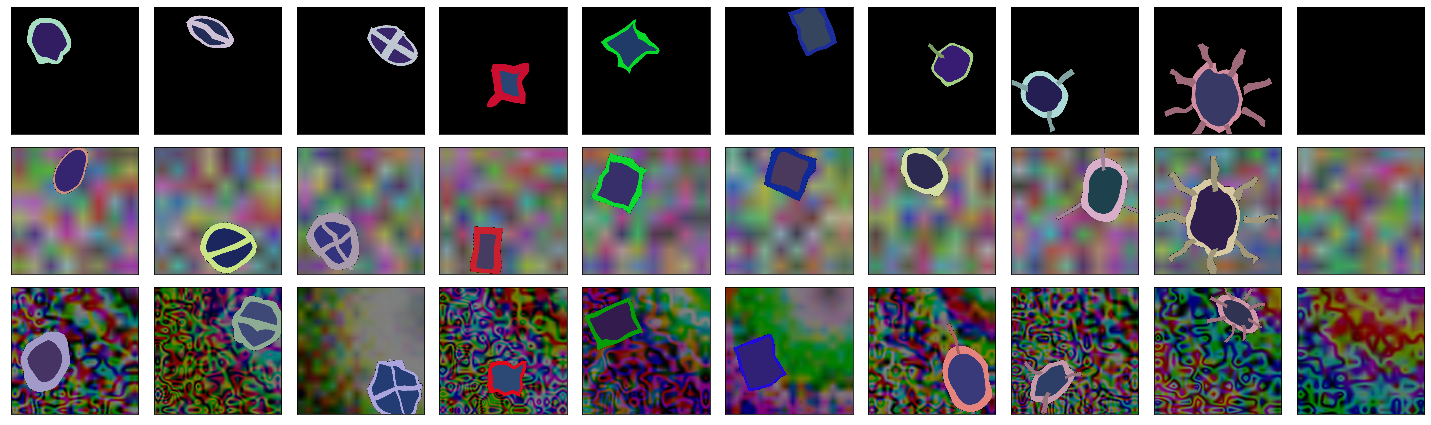

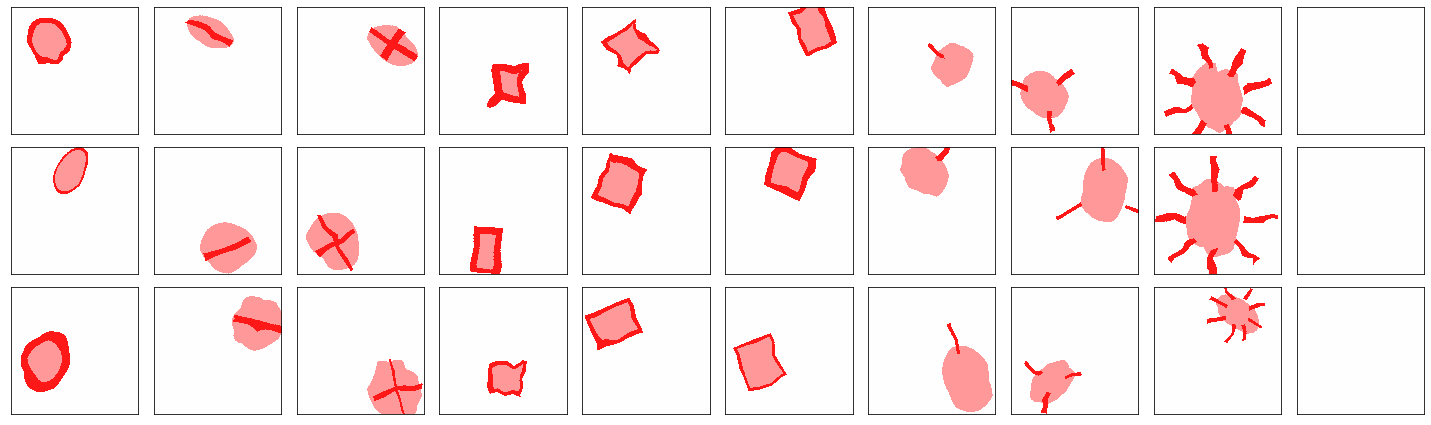

In [6]:
N_classes, N_bg = 10, 3
fig_settings = []
fig_layout = (N_bg,N_classes)
fig_settings_heatmaps = []

for j in range(N_bg):
    for i in range(N_classes):
        y0, bg_rand = i, j
        progress = '%s/%s | %s/%s'%(str(i+1),str(N_classes),str(j+1),str(N_bg)) 
        print('%-48s'%(str(progress)),end='\r')
        
        ###################################################################
        """
        One line code to generate a sample
        """     
        cobj, cimg, heatmap, variables = data_sampler.draw_one_sample(y0, bg_rand)
        ###################################################################
        
        fig_settings.append((fig_layout+(N_classes*j + (i+1),), cimg, None, False))
        fig_settings_heatmaps.append((fig_layout+(N_classes*j + (i+1),), heatmap, None, True))

create_multi_axes_figures(fig_settings, figsize=(20,6))
create_multi_axes_figures(fig_settings_heatmaps, figsize=(20,6), off_heatmap=True)

## Fetching data randomly
So, if we want to randomly draw a sample, you can generate your own random numbers as the following

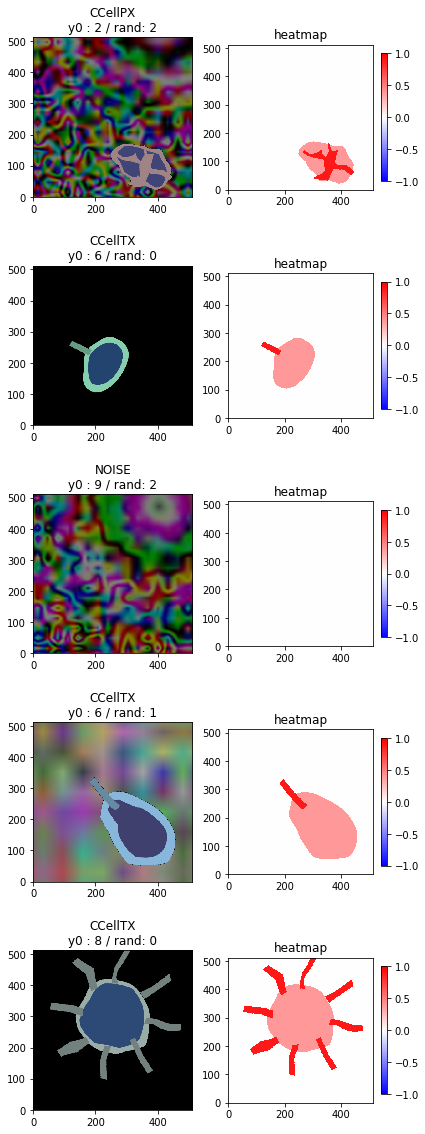

In [7]:
import numpy as np
N = 5
fig_settings3 = []
fig_layout = (N,2)
for i in range(1,1+N):
    y0 = np.random.randint(10)
    bg_rand = np.random.randint(3)
    
    ##########################################################################
    cobj, cimg, heatmap, variables = data_sampler.draw_one_sample(y0, bg_rand)
    ##########################################################################
    
    fig_settings3.append((fig_layout+(2*i-1,), cimg, '%s\ny0 : %s / rand: %s'%(str(variables['type']),
        str(variables['y0']),str(variables['bg_rand'])), False))
    fig_settings3.append((fig_layout+(2*i,), heatmap, 'heatmap', True))
create_multi_axes_figures(fig_settings3, figsize=(6,np.max((16*int(N/5),5))), off_ticks=False, off_heatmap=False)

Or equivalently use the predefined uniform random sampler

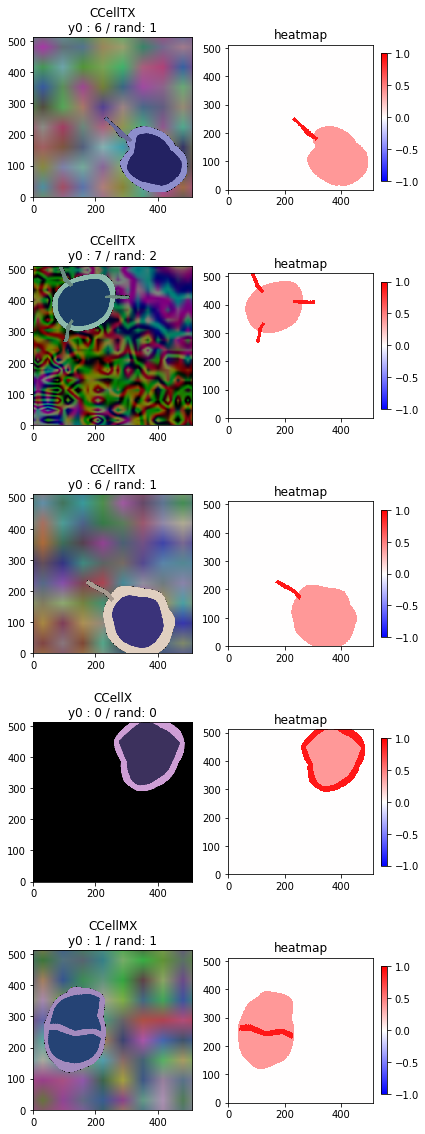

In [8]:
N = 5
fig_settings4 = []
fig_layout = (N,2)
for i in range(1,1+N):    
    ##########################################################################
    cobj, cimg, heatmap, variables = data_sampler.uniform_random_draw()
    ##########################################################################
    
    fig_settings4.append((fig_layout+(2*i-1,), cimg, '%s\ny0 : %s / rand: %s'%(str(variables['type']),
        str(variables['y0']),str(variables['bg_rand'])), False))
    fig_settings4.append((fig_layout+(2*i,), heatmap, 'heatmap', True))
create_multi_axes_figures(fig_settings4, figsize=(6,np.max((16*int(N/5),5))), off_ticks=False, off_heatmap=False)

## Done!
We have seen colored images and their heatmaps marking their distinguishing features. See the next tutorial on how to prepare them using pytorch API.